# Прогнозирование оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. Цель работы - необходимо предсказать, уйдёт ли клиент.
Для этого выполним следующие шаги:
1. Предобработка данных

   1.1. Импорт библиотек
   
   1.2. Загрузка датасетов
   
   1.3. Предварительный анализ данных
   
   1.4. Обработка данных

   1.5. Разделение на выборки
   
   1.6. Стандартизация численных признаков
   
   1.7. Кодирование категориальных признаков
   

2. Исследовательский анализ данных

   2.1. Исследование баланса классов
   
   2.2. Изучение распределения признаков
   
   2.3. Исследование корреляции признаков
   

3. Обучение моделей

   3.1. Light GBM
   
   3.2. Cat Boost

   3.3. Random Forest

   3.4. Logistic Regression
   
   3.5. Изучение важности признаков
   
   
4. Тестирование модели


5. Вывод

## Предобработка данных

### Импорт библиотек

In [1]:
#!pip install phik
#!pip install scikit-learn
#!pip install matplotlib
#!pip install seaborn
import os
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import phik
from phik.report import plot_correlation_matrix
from phik import report
from tqdm import tqdm

In [2]:
RANDOM_STATE = 80523

### Загрузка датасетов

In [3]:
def import_df(pth1, pth2):

    if os.path.exists(pth1):
        df = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        df = pd.read_csv(pth2)
    else:
        print('Something is wrong')
    return df

In [4]:
contract = import_df('contract_new.csv', '/datasets/contract_new.csv')
personal = import_df('personal_new.csv', '/datasets/personal_new.csv')
internet = import_df('internet_new.csv', '/datasets/internet_new.csv')
phone = import_df('phone_new.csv', '/datasets/phone_new.csv')

### Предварительный анализ данных

In [5]:
df_list = [contract, personal, internet, phone]
df_names = ['contract', 'personal', 'internet', 'phone']

In [6]:
for i, df in enumerate(df_list):
    print(df_names[i])
    print()    
    print('Размер датафрейма:')
    display(df.shape)
    display(df.info())
    display(df.head())
    display(df.describe())
    print('Количество пропусков:')
    print(df.isna().sum())
    print('Количество дубликатов:', df.duplicated().sum())
    print()

contract

Размер датафрейма:


(7043, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Количество пропусков:
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
Количество дубликатов: 0

personal

Размер датафрейма:


(7043, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Количество пропусков:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
Количество дубликатов: 0

internet

Размер датафрейма:


(5517, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Количество пропусков:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
Количество дубликатов: 0

phone

Размер датафрейма:


(6361, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Количество пропусков:
customerID       0
MultipleLines    0
dtype: int64
Количество дубликатов: 0



### Обработка данных

Объединим датасеты по общему столбцу customerID.

In [7]:
df = contract.merge(personal, on='customerID', how='outer')
df = df.merge(internet, on='customerID', how='outer')
df = df.merge(phone, on='customerID', how='outer')
print(df.head()) 

   customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  gender  \
0           Electronic check           29.85        31.04  Female   
1               Mailed check           56.95      2071.84    Male   
2               Mailed check           53.85       226.17    Male   
3  Bank transfer (automatic)           42.30       1960.6    Male   
4           Electronic check           70.70        353.5  Female   

   SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0              0     Yes         No             DSL             No   
1              0      No

In [8]:
shape = df.shape
print('Размер таблицы:', df.shape)

Размер таблицы: (7043, 20)


Приведем названия признаков к нижнему регистру.

In [9]:
df.columns = df.columns.str.lower()

Переименуем названия признаков.

In [10]:
df = df.rename(
    columns = {
        'customerid': 'customer_id', 'begindate': 'begin_date', 'enddate': 'end_date',
        'paperlessbilling': 'paper_lessbilling','paymentmethod': 'payment_method',
        'monthlycharges': 'monthly_charges', 'totalcharges': 'total_charges',
        'seniorcitizen': 'senior_citizen', 'internetservice': 'internet_service',
        'onlinesecurity': 'online_security', 'onlinebackup': 'online_backup',
        'deviceprotection': 'device_protection', 'techsupport': 'tech_support',
        'streamingtv': 'streaming_tv', 'streamingmovies': 'streaming_movies', 
        'multiplelines': 'multiple_lines'
    }
)

По действующим договорам в столбце 'end_date' укажем дату выгрузки датасета.

In [11]:
df.loc[df['end_date']=='No', 'end_date'] = '2020-02-01'

Добавим новый признак - длительность контракта.

In [12]:
df[['begin_date', 'end_date']] = df[['begin_date', 'end_date']].apply(pd.to_datetime)
df['contract_duration'] = (df['end_date'] - df['begin_date'])

In [13]:
df['contract_duration'] = df['contract_duration'].astype('timedelta64[D]').astype(np.int64)

Создадим столбец с целевым признаком 'exited', где 0 - лояльный клиент, 1 - клиент, расторгнувший договор.

In [14]:
df.loc[df['end_date']=='2020-02-01', 'exited'] = 0
df.loc[df['end_date']!='2020-02-01', 'exited'] = 1
df['exited'] = df['exited'].astype(np.int64)

Удалим неинформативные признаки: 'customer_id', 'begin_date', 'end_date'.

In [15]:
df = df.drop(['customer_id', 'begin_date', 'end_date'], axis=1)

Проверим количество пропусков в %.

In [16]:
pd.DataFrame(round(df.isna().mean()*100,3)).style.background_gradient('coolwarm')

,0
type,0.000000
paper_lessbilling,0.000000
payment_method,0.000000
monthly_charges,0.000000
total_charges,0.000000
gender,0.000000
senior_citizen,0.000000
partner,0.000000
dependents,0.000000
internet_service,21.667000


Если нет данных о подключенной услуге, то, скорее всего, эта услуга не подключена. Поэтому заменим пропуски значениями No.

In [17]:
#список признаков, где нужно заменить значения на No
list = ('internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 
        'streaming_movies', 'multiple_lines')

In [18]:
for i in list:
    df[i] = df[i].fillna('No')

Изучим количество строк, где не заполнено поле 'total_charges'.

In [19]:

len(df[df['total_charges']==' '])

11

Удалим строки, где не заполнено поле 'total_charges'.

In [20]:
df = df[df['total_charges']!=' ']
df['total_charges'] = df['total_charges'].astype(np.float64)

In [21]:
df['senior_citizen'] = df['senior_citizen'].astype(object) 

In [22]:
df_full = df.copy()

In [23]:
df_full.loc[df_full['senior_citizen']==0, 'senior_citizen'] = 'No'
df_full.loc[df_full['senior_citizen']==1, 'senior_citizen'] = 'Yes'

Удалим признак 'monthly_charges' для устранения мультиколлинеарности, изученной в следующем разделе.

In [24]:
print('Размер преобразованной таблицы:', df.shape)

Размер преобразованной таблицы: (7032, 19)


In [25]:
print('Удалено:', round((df.shape[0]/shape[0]-1)*(-100), 2), '% строк')

Удалено: 0.16 % строк


### Разделение на выборки

Извлечем признаки.

In [26]:
target = df['exited'] #извлечем целевой признак
features = df.drop(['exited'] , axis=1) #извлечем признаки 

Разделим данные на обучающую и тестовую выборки в соотношении 75% и 25% соответственно, применяя стратификацию.

In [27]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                    train_size=0.75, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=target)

In [28]:
print('Строк в тренировочной выборке:', target_train.shape[0])
print('Строк в тестовой выборке:', target_test.shape[0])

Строк в тренировочной выборке: 5274
Строк в тестовой выборке: 1758


In [29]:
round(target_test.shape[0]/df.shape[0], 2)

0.25

### Стандартизация численных признаков

Выделим числовые признаки в список.

In [30]:
numeric = ['total_charges', 'contract_duration', 'monthly_charges']

In [31]:
features_train_lr = features_train.copy()
features_test_lr = features_test.copy()

scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train_lr[numeric] = scaler.transform(features_train[numeric])
features_test_lr[numeric] = scaler.transform(features_test[numeric])

### Кодирование категориальных признаков

Выделим категориальные признаки в список.

In [32]:
cat_features = features_train.select_dtypes(include='object').columns.to_list() 

Закодируем категориальные признаки методом OrdinalEncoder для LightGBM, CatBoost и случайного леса.

In [33]:
encoder_oe = OrdinalEncoder()

In [34]:
features_train_oe = features_train.copy()
encoder_oe.fit(features[cat_features])
features_train_oe[cat_features] = encoder_oe.transform(features_train[cat_features])
features_train_oe.head()

,type,paper_lessbilling,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_duration
4333,0.0,1.0,1.0,90.55,2947.40,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,945
151,0.0,0.0,3.0,95.00,790.40,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,245
1385,2.0,1.0,1.0,102.50,5313.60,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1461
1883,0.0,1.0,0.0,100.50,2542.65,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,699
4838,1.0,1.0,1.0,109.70,8011.39,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2041


In [35]:
features_test_oe = features_test.copy()
features_test_oe[cat_features] = encoder_oe.transform(features_test[cat_features])
features_test_oe.head()

,type,paper_lessbilling,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_duration
6098,1.0,1.0,0.0,75.90,1593.90,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,641
995,0.0,0.0,1.0,85.30,511.80,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,181
5209,2.0,1.0,1.0,109.95,8153.89,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2191
6596,1.0,0.0,2.0,81.25,5200.00,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1949
1443,0.0,1.0,3.0,55.80,167.40,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,92


Закодируем категориальные признаки методом OHE для логистической регрессии.

In [36]:
column_trans = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                        cat_features),
                                        remainder='passthrough')

<b>ВЫВОД.</b> 
Датасеты размерами (7043, 8), (7043, 5), (5517, 8), (6361, 2) были исследованы, данные подготовлены для дальнейшего обучения: произведено объединение таблиц, обработаны пропуски, проверены дубликаты, рассчитан дополнительный признак, удалены неинформативные столбцы. Размер преобразованной таблицы: (7032, 18), удалено 0.16 % строк.
Произведено разделение на выборки, произведено масштабирование численных признаков, закодированы категориальные признаки методом OHE для логистической регрессии. Методом OrdinalEncoder закодированы категориальные признаки для остальных моделей.

## Исследовательский анализ данных

### Исследование баланса классов

Проверим баланс классов целевого признака.

0    0.84343
1    0.15657
Name: exited, dtype: float64

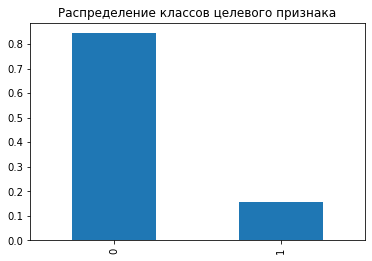

In [37]:
class_frequency = df['exited'].value_counts(normalize=True)
display(class_frequency)
class_frequency.plot(kind='bar', title='Распределение классов целевого признака');

Классы не сбалансированы. Исследуем модели как с балансировкой классов, так и без.

### Изучение распределения признаков

Изучим распределение признака 'monthly_charges'.

Чаще всего сумма ежемесячного платежа составляет около 20 у.е.

Изучим распределение признака 'total_charges'.

Гораздо больше клиентов, чьи суммарные траты составляют до 100 у.е. С увеличением суммы трат количество клиентов постепенно уменьшается. Максимальная сумма трат - 9221.38 у.е.

Изучим распределение признака 'contract_duration', переведенного в количество лет.

Чаще всего встречаются клиенты с длительностью контрактов до полугода. Так же можно заметить большое количество очень длительных контрактов: более 6 лет.

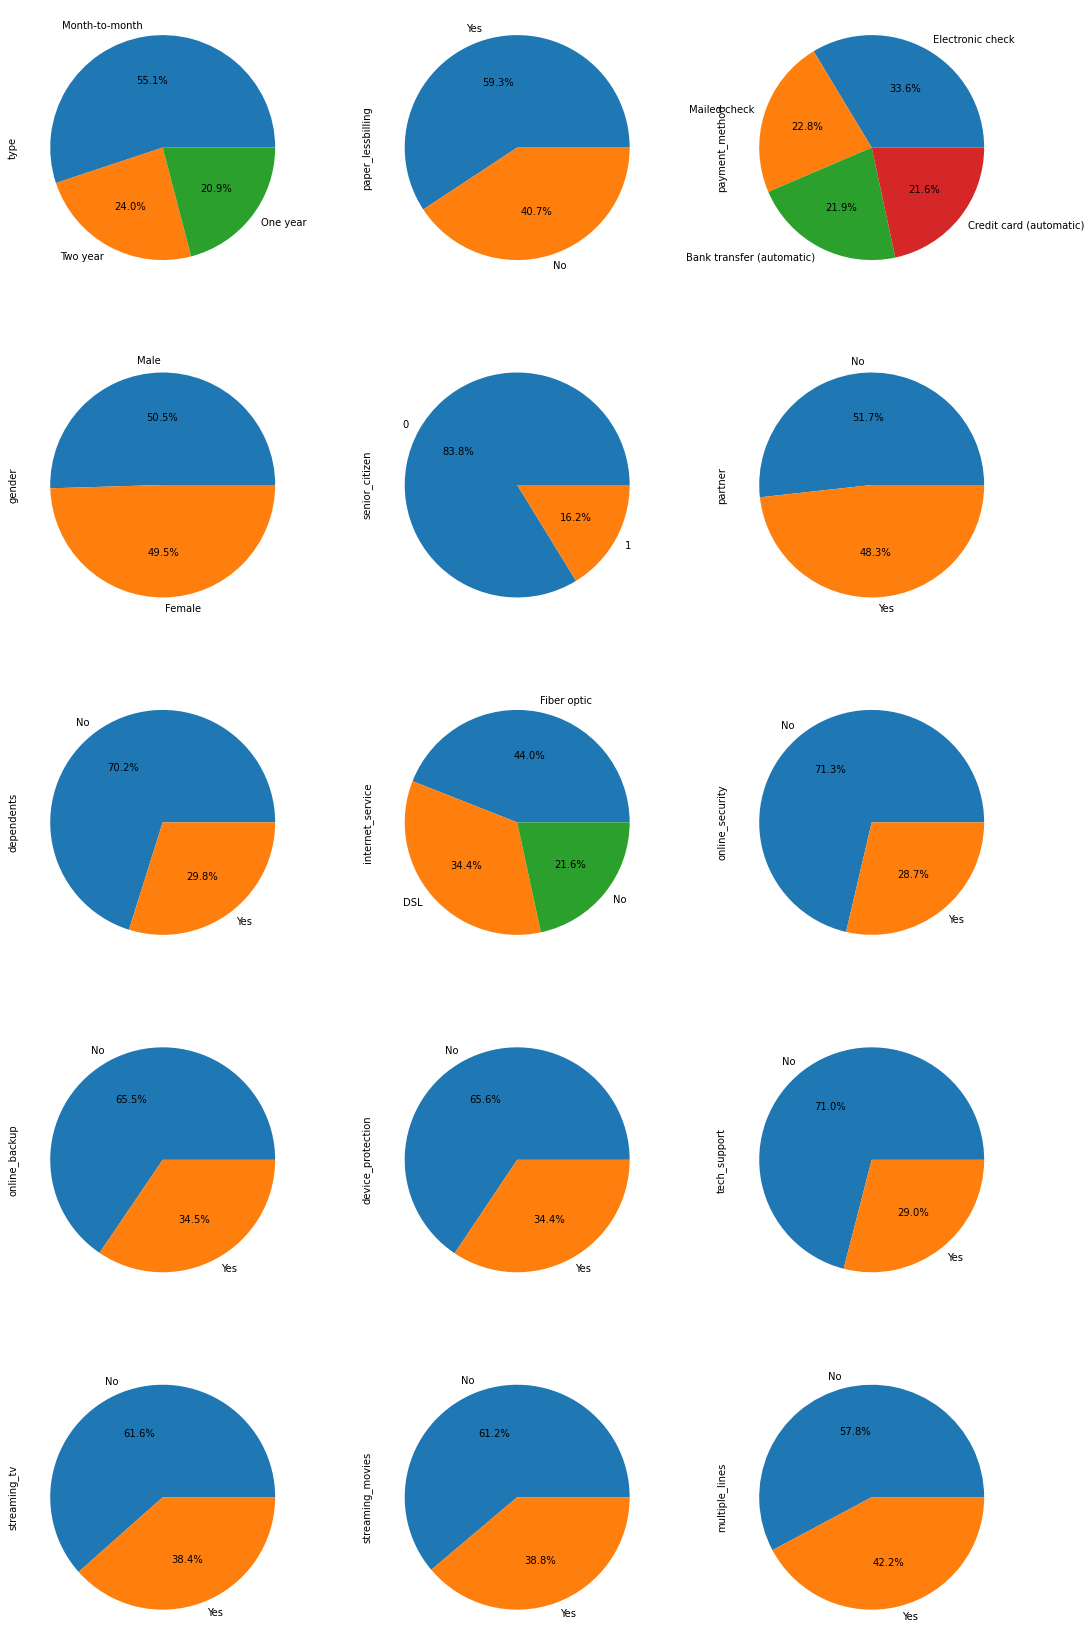

In [38]:
num_rows = 5
num_cols = 3

#cоздание сетки подграфиков
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 30))

#итерация по категориальным признакам и размещение диаграмм в сетке подграфиков
for i, col in enumerate(cat_features):
    if i < num_rows * num_cols:
        ax = axes[i // num_cols, i % num_cols]
        df[col].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax)

Если рассмотреть, как распределены категориальные признаки, то можно сделать следующие выводы: типичный клиент заключает договор с ежемесячной оплатой, пользуется безналичным расчетом с помощью электронный платежной системы, не имеет пенсионного статуса, без иждивенцев, пользуется услугами оптоволокна и не использует другие дополнительные услуги.

Изучим распределение признаков по лояльным и ушедшим клиентам.

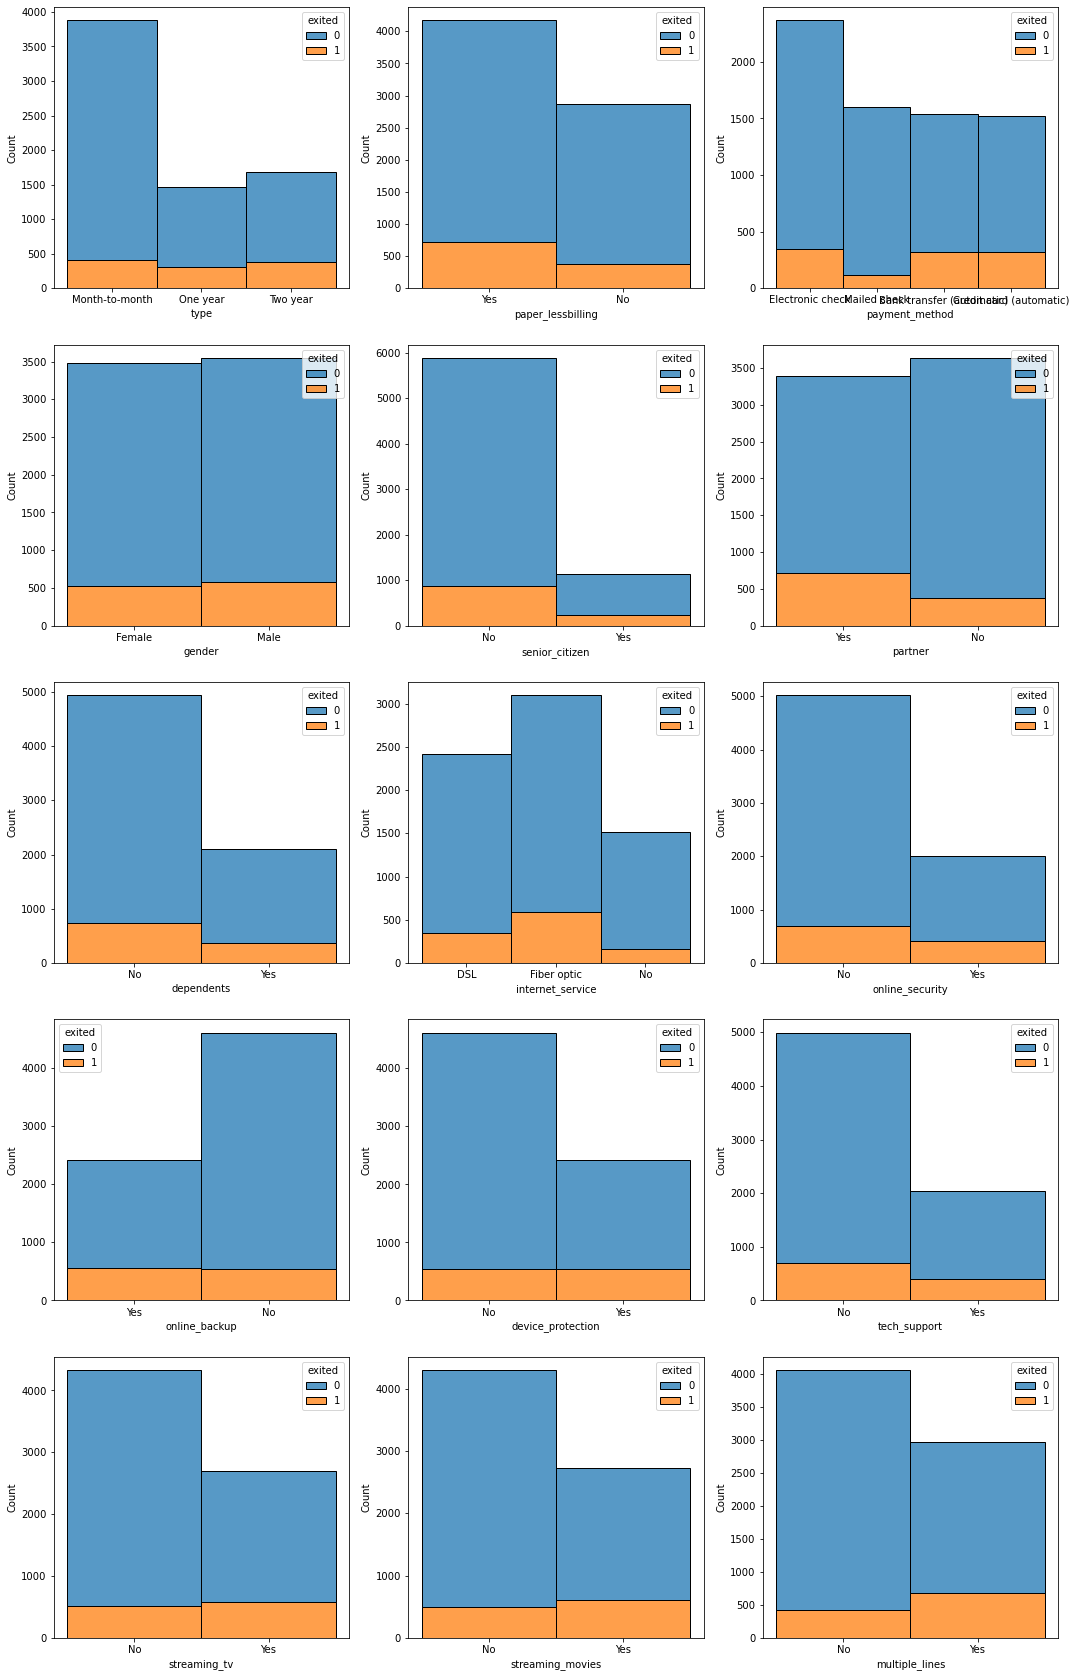

In [39]:
num_rows = 5
num_cols = 3

#cоздание сетки подграфиков
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 30))

#итерация по признакам и размещение диаграмм в сетке подграфиков
for i, col in enumerate(cat_features):
    if i < num_rows * num_cols:
        ax = axes[i // num_cols, i % num_cols]
        sns.histplot(df_full, x = col, hue = 'exited', multiple = 'stack', ax=ax)

Если рассмотреть, как распределены категориальные признаки, то можно сделать следующие выводы для лояльного типичного клиента: 
заключает договор с ежемесячной оплатой, пользуется безналичным расчетом с помощью электронный платежной системы, не имеет пенсионного статуса, без иждивенцев, пользуется услугами оптоволокна и не использует другие дополнительные услуги.

Клиенты, склонные к расторжению договора, пользуются безналичным расчетом, реже отправляют чек по почте, не являются пенсионерами, имеют партнера, не имеют иждивенцев, пользуются технологиями оптоволокна, не пользуются услугами безопасности,  тех.поддержки, но имеют многоканальную линию.

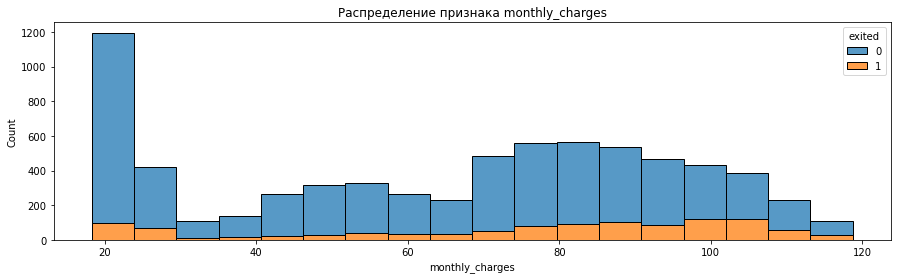

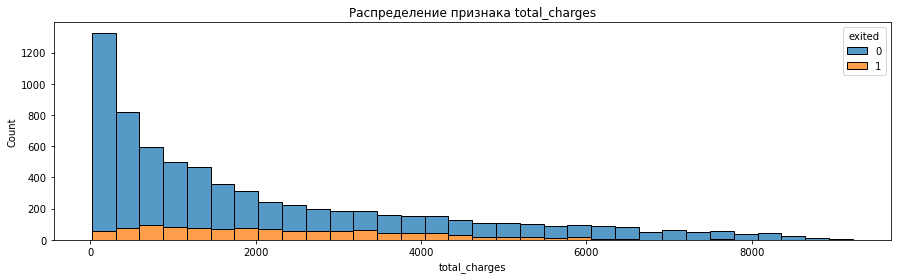

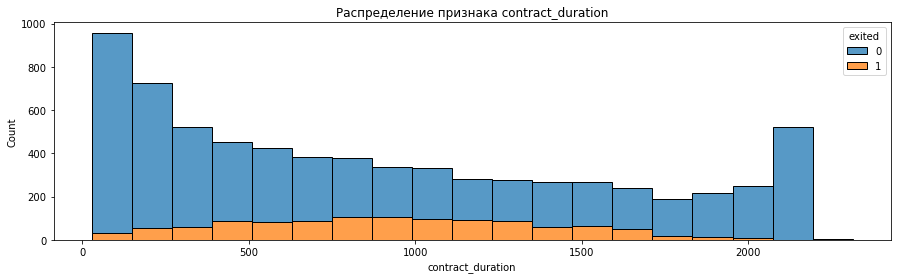

In [40]:
num_list = ['monthly_charges', 'total_charges', 'contract_duration']
for i in num_list:
    plt.figure(figsize=(15, 4))
    sns.histplot(df_full, x = i, hue = 'exited', multiple = 'stack')
    plt.title('Распределение признака '+i)
    plt.show()

У лояльных клиентов чаще всего сумма ежемесячного платежа составляет около 20 у.е.
Гораздо больше клиентов, чьи суммарные траты составляют до 100 у.е. С увеличением суммы трат количество клиентов постепенно уменьшается. Максимальная сумма трат - 9221.38 у.е. Чаще всего встречаются клиенты с длительностью контрактов до полугода. Так же можно заметить большое количество очень длительных контрактов: более 6 лет. 

Для типичного клиента, который планирует уйти, ежемесячные расходы соствляют около 100 у.е., реже - около 20 у.е., суммарные расходы около 800-900 у.е., длительность контракта от года до 1,5 лет.

### Исследование корреляции признаков

In [41]:
phik_overview = df_full.phik_matrix().round(2)

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'contract_duration', 'exited']


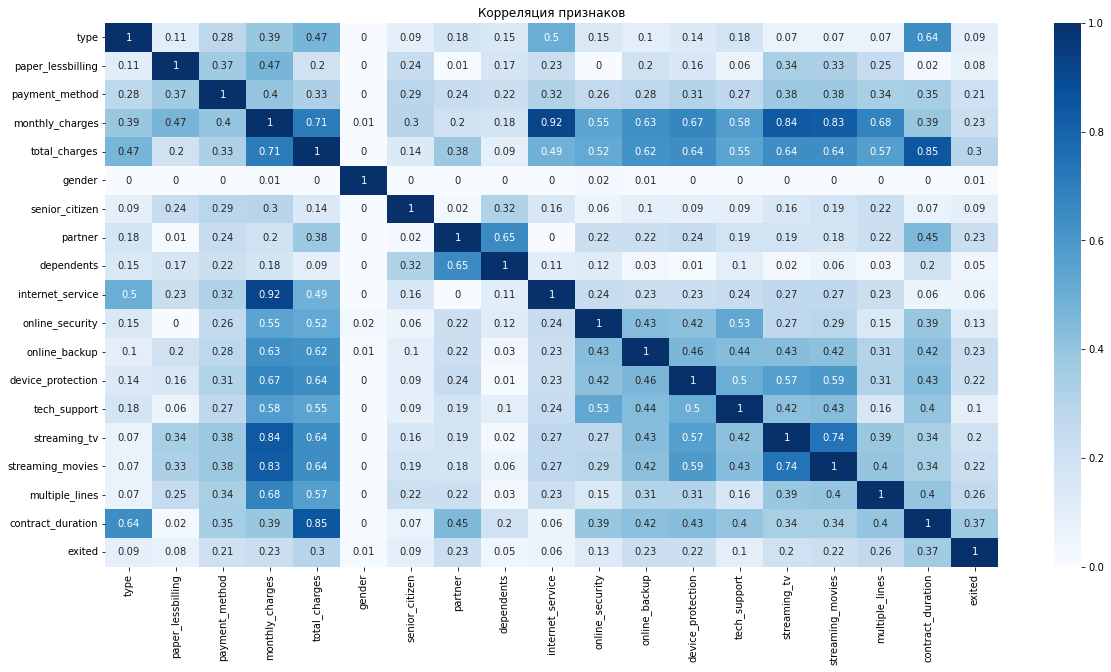

In [42]:
plt.figure(figsize=(20, 10))
sns.heatmap(phik_overview, annot=True,cmap='Blues')
plt.title('Корреляция признаков')
plt.show()

Между целевым признаком exited и остальными признаками нет сильной корреляции.

Наибольшую зависимость можно отметить между признаками:
monthly_charges-internet_service;
monthly_charges-streaming_tv;
monthly_charges-streaming_movies,
total_charges-contract_duration.
Таким образом, на ежемесячные расходы клиентов больше всего оказывают влияние услуги internet_service, streaming_tv, streaming_movies, на суммарные расходы - длительность контракта. 

Для устранения мультиколлинеарности удалили признак monthly_charges из датасета в разделе обработки данных.

<b>ВЫВОД.</b> Проведен исследовательских анализ данных. Классы целевого признака не сбалансированы. Исследована корреляция между признаками.
У лояльных клиентов чаще всего сумма ежемесячного платежа составляет около 20 у.е.
Гораздо больше клиентов, чьи суммарные траты составляют до 100 у.е. С увеличением суммы трат количество клиентов постепенно уменьшается. Максимальная сумма трат - 9221.38 у.е. Чаще всего встречаются клиенты с длительностью контрактов до полугода. Так же можно заметить большое количество очень длительных контрактов: более 6 лет, заключает договор с ежемесячной оплатой, пользуется безналичным расчетом с помощью электронный платежной системы, не имеет пенсионного статуса, без иждивенцев, пользуется услугами оптоволокна и не использует другие дополнительные услуги.

Клиенты, склонные к расторжению договора, имеют ежемесячные расходы около 100 у.е., реже - около 20 у.е., суммарные расходы около 800-900 у.е., длительность контракта от года до 1,5 лет, пользуются безналичным расчетом, реже отправляют чек по почте, не являются пенсионерами, имеют партнера, не имеют иждивенцев, пользуются технологиями оптоволокна, не пользуются услугами безопасности, тех.поддержки, но имеют многоканальную линию, 

Между целевым признаком exited и остальными признаками нет сильной корреляции, но присутствует сильная связь между другими признаками: monthly_charges-internet_service;
monthly_charges-streaming_tv;
monthly_charges-streaming_movies,
total_charges-contract_duration.

## Обучение моделей

### Light GBM

In [43]:
%%time

gbm = lgb.LGBMClassifier(random_state=RANDOM_STATE)

gbm_parametrs = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3], 
               'max_depth': range(2, 11),
               'num_leaves': [30, 40, 50],
               'n_estimators': [100, 200, 300]
             }

gbm_grid = GridSearchCV(gbm, gbm_parametrs, scoring='roc_auc', cv=5, n_jobs=-1, verbose=10)
begin = time.time()
gbm_grid.fit(features_train_oe, target_train)
end = time.time()
time_gbm = round(end-begin)
print('Время обучения LightGBM:',time_gbm)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Время обучения LightGBM: 77
CPU times: total: 11.7 s
Wall time: 1min 17s


In [44]:
gbm_params = gbm_grid.best_params_
print(gbm_params)

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 300, 'num_leaves': 30}


In [45]:
gbm_scores = gbm_grid.best_score_.round(4)
print('AUC-ROC LightGBM:', gbm_scores)

AUC-ROC LightGBM: 0.896


### Cat Boost

In [46]:
%%time

cb = CatBoostClassifier(random_state=RANDOM_STATE)

cb_parametrs = {'learning_rate': [0.1, 0.2, 0.3], 
                'max_depth': range(1, 6),
                'iterations': [400, 500, 600, 700, 800],
                'l2_leaf_reg': [1, 10],
                'bagging_temperature': [0.5, 1],
                'border_count': [100, 200]
                }

cb_grid = GridSearchCV(cb, cb_parametrs, scoring='roc_auc', cv=5, n_jobs=-1, verbose=10)
begin = time.time()
cb_grid.fit(features_train_oe, target_train, verbose=True)
end = time.time()
time_cb = round(end-begin)
print('Время обучения CatBoost:', time_cb)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
0:	learn: 0.5357295	total: 146ms	remaining: 1m 27s
1:	learn: 0.4473351	total: 148ms	remaining: 44.4s
2:	learn: 0.4159787	total: 150ms	remaining: 29.9s
3:	learn: 0.3919305	total: 153ms	remaining: 22.8s
4:	learn: 0.3748402	total: 155ms	remaining: 18.5s
5:	learn: 0.3658519	total: 158ms	remaining: 15.6s
6:	learn: 0.3589250	total: 160ms	remaining: 13.5s
7:	learn: 0.3529680	total: 162ms	remaining: 12s
8:	learn: 0.3470586	total: 165ms	remaining: 10.8s
9:	learn: 0.3445898	total: 167ms	remaining: 9.84s
10:	learn: 0.3418674	total: 169ms	remaining: 9.05s
11:	learn: 0.3384277	total: 171ms	remaining: 8.39s
12:	learn: 0.3321652	total: 174ms	remaining: 7.83s
13:	learn: 0.3306482	total: 176ms	remaining: 7.35s
14:	learn: 0.3289037	total: 178ms	remaining: 6.96s
15:	learn: 0.3273787	total: 181ms	remaining: 6.59s
16:	learn: 0.3265542	total: 183ms	remaining: 6.27s
17:	learn: 0.3233036	total: 186ms	remaining: 6s
18:	learn: 0.3214219	total: 188m

In [47]:
cb_params = cb_grid.best_params_
print(cb_params)

{'bagging_temperature': 0.5, 'border_count': 200, 'iterations': 600, 'l2_leaf_reg': 1, 'learning_rate': 0.3, 'max_depth': 2}


In [48]:
cb_scores = cb_grid.best_score_.round(4)
print('AUC-ROC CatBoost:', cb_scores)

AUC-ROC CatBoost: 0.9253


### Random Forest

In [49]:
%%time

rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_parametrs = {'n_estimators': range(5, 150, 30),
                'max_depth': range(2, 15),
                'class_weight' : ['balanced', None]
                }

rf_grid = GridSearchCV(rf, rf_parametrs, scoring='roc_auc', cv=3, n_jobs=-1, verbose=10)
begin = time.time()
rf_grid.fit(features_train_oe, target_train)
end = time.time()
time_rf = end-begin
print(time_rf)

Fitting 3 folds for each of 130 candidates, totalling 390 fits
19.15566897392273
CPU times: total: 2.67 s
Wall time: 19.2 s


In [50]:
rf_params = rf_grid.best_params_
print(gbm_params)

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 300, 'num_leaves': 30}


In [51]:
rf_scores = rf_grid.best_score_.round(4)
print('F1 AUC-ROC RandomForest:', rf_scores)

F1 AUC-ROC RandomForest: 0.8294


### Logistic Regression

In [52]:
%%time

lr = LogisticRegression(random_state=RANDOM_STATE)
pipe = make_pipeline(column_trans, lr)
parameters = {
    'logisticregression__C': [1,2,6],
    'logisticregression__class_weight':['balanced', None],
}

lr_grid = RandomizedSearchCV(pipe, parameters, cv=3, n_jobs=-1, scoring='roc_auc', verbose=3)
begin = time.time()
lr_grid.fit(features_train_lr, target_train)
end = time.time()
time_lr = end-begin
print(time_lr)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\iliny\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.5183658599853516
CPU times: total: 359 ms
Wall time: 519 ms


In [53]:
lr_params = lr_grid.best_params_
print(lr_params)

{'logisticregression__class_weight': None, 'logisticregression__C': 1}


In [54]:
lr_scores = lr_grid.best_score_.round(4)
print('AUC-ROC LinearRegression:', lr_scores)

AUC-ROC LinearRegression: 0.7749


In [55]:
columns = ['Модель', 'Время обучения модели', 'AUC-ROC']
gbm = ['LightGBM', time_gbm, gbm_scores]
cb = ['CatBoost', time_cb, cb_scores]
rf = ['RandomForest', time_rf, rf_scores]
lr = ['LogisticRegression', time_lr, lr_scores]

table = pd.DataFrame([gbm, cb, rf, lr], columns = columns)
display(table)

,Модель,Время обучения модели,AUC-ROC
0,LightGBM,77.000000,0.8960
1,CatBoost,1464.000000,0.9253
2,RandomForest,19.155669,0.8294
3,LogisticRegression,0.518366,0.7749


### Изучение важности признаков

Обучим лучшую модель с подобранными параметрами.

In [56]:
final_model_cb = CatBoostClassifier(
    bagging_temperature=0.5,
    border_count=200,
    iterations=600,
    l2_leaf_reg=1,
    learning_rate=0.3,
    max_depth=2,
    random_state=RANDOM_STATE,
    verbose=False
)
final_model_cb.fit(features_train_oe, target_train)

#получим важность признаков
importances = final_model_cb.feature_importances_
feature_importances = pd.DataFrame({'feature': features_train.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

print(feature_importances)

              feature  importance
17  contract_duration   73.350660
4       total_charges    7.406253
3     monthly_charges    6.042795
0                type    3.421129
7             partner    1.736292
2      payment_method    1.513304
16     multiple_lines    1.502302
11      online_backup    0.810129
12  device_protection    0.795317
15   streaming_movies    0.668179
6      senior_citizen    0.666321
8          dependents    0.465611
14       streaming_tv    0.361711
1   paper_lessbilling    0.338521
5              gender    0.332120
10    online_security    0.304700
13       tech_support    0.231895
9    internet_service    0.052761


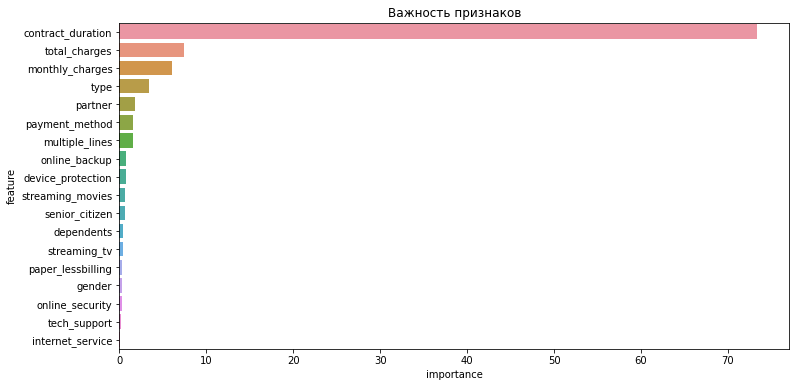

In [57]:
plt.rcParams['figure.figsize']=(12,6)
feature_importances_barplot = sns.barplot(y= 'feature', x = 'importance', data = feature_importances)
feature_importances_barplot.set_title('Важность признаков');

<b>ВЫВОД.</b> Исследованы модели LightGBM, CatBoost, RandomForest и LogisticRegression. В моделях рассмотрены варианты в том числе с балансировкой классов. Лучшей по метрике AUC-ROC является модель CatBoost с параметрами: {'bagging_temperature': 0.5, 'border_count': 200, 'iterations': 600, 'l2_leaf_reg': 1, 'learning_rate': 0.3, 'max_depth': 2}. AUC-ROC на кросс-валидации составляет 0.9253.
Наиболее важным признаком модели является признак 'contract_duration'.

## Тестирование модели

Проверим качество модели CatBoost на тестовой выборке.

In [58]:
test_proba_cb = cb_grid.predict_proba(features_test_oe)
print("AUC-ROC CatBoost на тестовой выборке:", round(roc_auc_score(target_test, test_proba_cb[:, 1]),4))

AUC-ROC CatBoost на тестовой выборке: 0.9222


На тестовой выборке AUC-ROC обученной модели CatBoostClassifier с параметрами {'bagging_temperature': 0.5, 'border_count': 200, 'iterations': 600, 'l2_leaf_reg': 1, 'learning_rate': 0.3, 'max_depth': 2} составляет 0.9222, что удовлетворяет условию
задачи. 

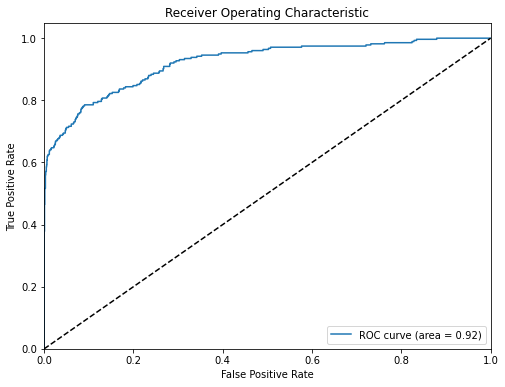

In [59]:
probas = cb_grid.predict_proba(features_test_oe)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probas)
roc_auc = auc(fpr, tpr)

#построение ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

## Вывод

Для решения задачи бинарной классификации в телекоммуникационной компании - предсказания уйдет ли клиент или нет- были предоставлены датасеты размерами (7043, 8), (7043, 5), (5517, 8), (6361, 2). Они были исследованы, данные подготовлены для дальнейшего обучения: 
- произведено объединение таблиц методом merge; 
- пропуски в признаках, обозначающих наличие дополнительных услуг, заполнены значением 'No'; отсутствующие значения в признаке 'total_charges', были удалены, т.к. их количество незначительно (11 строк- 0.16%);
- проверены дубликаты;
- рассчитан дополнительный признак 'contract_duration';
- удалены столбцы с датой начала и окончания действия договора, 'customer_id' как неинформативные.

Размер преобразованной таблицы: (7032, 19), удалено 0.16 % строк. Произведено разделение на выборки в отношении 25% - тестовая выборка и 75% - тренировочная, масштабирование численных признаков, закодированы категориальные признаки методом OHE для логистической регрессии. Методом OrdinalEncoder закодированы категориальные признаки для остальных моделей.

Проведен исследовательских анализ данных. Классы целевого признака не сбалансированы. Исследована корреляция между признаками. 
Между целевым признаком exited и остальными признаками нет сильной корреляции, но присутствует сильная связь между другими признаками: monthly_charges-internet_service; monthly_charges-streaming_tv; monthly_charges-streaming_movies, total_charges-contract_duration.

Портрет типичного клиента: сумма ежемесячного платежа составляет около 20 у.е., суммарные траты составляют до 100 у.е., с длительностью контрактов до полугода, заключает договор с ежемесячной оплатой, пользуется безналичным расчетом с помощью электронный платежной системы, не имеет пенсионного статуса, без иждивенцев, пользуется услугами проведения оптоволокна и не использует другие дополнительные услуги.

Исследованы модели LightGBM, CatBoost, RandomForest и LogisticRegression. В моделях рассмотрены варианты в том числе с балансировкой классов. 
Лучшей по метрике AUC-ROC является модель CatBoost с параметрами: {'bagging_temperature': 0.5, 'border_count': 200, 'iterations': 600, 'l2_leaf_reg': 1, 'learning_rate': 0.3, 'max_depth': 2}. Наиболее важным признаком модели является признак 'contract_duration'. Метрика AUC-ROC на кросс-валидации составила 0.9253, на тестовой выборке - 0.9222, что удовлетворяет ТЗ.



## Отчет

### Введение

Сохранение лояльности клиентов является важным аспектом для бизнеса, т.к. это напрямую влияет на прибыль, ведь привлекать новых клиентов - горазо дороже. 
Для предотвращения оттока необходимо определить клиентов, которые могут в скором времени расторгнуть договор и произвести действия , например, отправить промокод, предложить новые услуги, новые условия и т.п. 

### Данные и предобработка

Для решения задачи были предоставлены датасеты:
1. contract размером (7043, 8) с информацией о контрактах;
2. personal размером (7043, 5) с персональной информацией;
3. internet размером (5517, 8) с информацией об интернет-услугах;
4. phone размером (6361, 2) с информацией о телефонных услугах.
 
Они были исследованы, данные подготовлены для дальнейшего обучения:
- произведено объединение таблиц методом merge;
- пропуски в признаках, обозначающих наличие дополнительных услуг, заполнены значением 'No'; отсутствующие значения в признаке 'total_charges', были удалены, т.к. их количество незначительно (11 строк- 0.16%);
проверены дубликаты;
- рассчитан дополнительный признак 'contract_duration' как разница между датой окончания и датой начала действия контракта;
- создан столбец с целевым признаком 'exited', где 0 - лояльный клиент, 1 - клиент, расторгнувший договор.
- удалены столбцы с датой начала и окончания действия договора, 'customer_id' как неинформативные.

Размер преобразованной таблицы: (7032, 19).
 
Исследовательский анализ данных показал, что классы целевого признака не сбалансированы. 
Между целевым признаком exited и остальными признаками нет сильной корреляции, но присутствует сильная связь между другими признаками: monthly_charges-internet_service; monthly_charges-streaming_tv; monthly_charges-streaming_movies, total_charges-contract_duration.
 
Произведено разделение на выборки в отношении 25% - тестовая выборка и 75% - тренировочная.
Для логистической регрессии  было произведено масштабирование численных признаков, закодированы категориальные признаки методом OHE. Методом OrdinalEncoder закодированы категориальные признаки для остальных моделей.

### Признаки

Для обучения модели были использованы признаки: ['type',
 'paper_lessbilling',
 'payment_method',
 'monthly_charges',
 'total_charges',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'contract_duration']

Наиболее важным признаком модели является признак 'contract_duration'.

### Модели

Исследованы модели LightGBM, CatBoost, RandomForest и LogisticRegression с параметром random_state = 80523.
В моделях исследованы различные параметры, в том числе с балансировкой классов.
Лучшей по метрике AUC-ROC является модель CatBoost с параметрами:

CatBoostClassifier(
    bagging_temperature=0.5,
    border_count=200,
    iterations=600,
    l2_leaf_reg=1,
    learning_rate=0.3,
    max_depth=2,
    random_state=80523
)

### Результаты

Метрика AUC-ROC на кросс-валидации составила 0.9253, на тестовой выборке - 0.9292, что удовлетворяет ТЗ.


Все пункты плана были выполнены. В отличие от исходного плана работ было добавлено исследование модели Cat Boost, т.к. изначально модели Light GBM, Random Forest, Logistic Regression не давали требуемого уровня метрики, а так же дополнительно изучена важность признаков. Трудностями в работе считаю изучение распределения признаков в разрезе уровня лояльности клиентов. Ключевыми считаю все проделанные этапы.